# Importare le Librerie Necessarie

In [14]:
import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import PPO
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import os
import torch
from stable_baselines3.common.utils import set_random_seed

In [15]:
# Imposta il seme per la riproducibilità
seed_value = 8

random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
set_random_seed(seed_value)

# Lettura dati

In [16]:
pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')

,Unnamed: 0,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,0,2014-09-17 00:00:00+00:00,359.546204,361.468506,351.586884,355.957367,16389166,0.0,0.0
1,1,2014-09-18 00:00:00+00:00,355.588409,355.505402,319.789459,328.539368,26691849,0.0,0.0
2,2,2014-09-19 00:00:00+00:00,328.278503,330.936707,298.921021,307.761139,29560103,0.0,0.0
3,3,2014-09-20 00:00:00+00:00,307.665253,329.978180,303.931244,318.758972,28736826,0.0,0.0
4,4,2014-09-21 00:00:00+00:00,318.120514,321.504517,306.502197,310.632446,20702625,0.0,0.0
...,...,...,...,...,...,...,...,...,...
3503,3503,2024-04-20 00:00:00+00:00,59675.082031,61440.464844,56170.074219,59876.710938,46818669689,0.0,0.0
3504,3504,2024-04-21 00:00:00+00:00,59883.777344,61376.257812,59247.250000,60956.074219,21662346331,0.0,0.0
3505,3505,2024-04-22 00:00:00+00:00,60954.554688,61639.593750,60245.773438,60919.242188,19240933719,0.0,0.0
3506,3506,2024-04-23 00:00:00+00:00,60927.675781,63113.457031,60496.617188,62729.296875,26544206489,0.0,0.0


In [17]:
dati_originali = pd.read_csv('Bitcoin (€) da yfinance dal 17-09-2014 al 24-04-2024.csv')
dati_originali = dati_originali[['Date', 'Close', 'Open', 'High', 'Low', 'Volume']]
dati_originali = dati_originali.rename(columns = {'Date':'Timestamp', 'Close': 'Price'})
dati_originali['Timestamp'] = pd.to_datetime(dati_originali['Timestamp'])
dati_originali['Timestamp'] = dati_originali['Timestamp'].dt.strftime('%Y-%m-%d')
dati_originali['Timestamp'] = pd.to_datetime(dati_originali['Timestamp'], format='%Y-%m-%d')
dati_originali

,Timestamp,Price,Open,High,Low,Volume
0,2014-09-17,355.957367,359.546204,361.468506,351.586884,16389166
1,2014-09-18,328.539368,355.588409,355.505402,319.789459,26691849
2,2014-09-19,307.761139,328.278503,330.936707,298.921021,29560103
3,2014-09-20,318.758972,307.665253,329.978180,303.931244,28736826
4,2014-09-21,310.632446,318.120514,321.504517,306.502197,20702625
...,...,...,...,...,...,...
3503,2024-04-20,59876.710938,59675.082031,61440.464844,56170.074219,46818669689
3504,2024-04-21,60956.074219,59883.777344,61376.257812,59247.250000,21662346331
3505,2024-04-22,60919.242188,60954.554688,61639.593750,60245.773438,19240933719
3506,2024-04-23,62729.296875,60927.675781,63113.457031,60496.617188,26544206489


In [18]:
data_inizio = '2014-09-17'
data_fine = '2023-12-31'
indice_inizio = dati_originali[dati_originali['Timestamp'] == data_inizio].index[0]
indice_fine = dati_originali[dati_originali['Timestamp'] == data_fine].index[0]
dati = dati_originali[indice_inizio:indice_fine + 1].reset_index(drop=True)
dati

,Timestamp,Price,Open,High,Low,Volume
0,2014-09-17,355.957367,359.546204,361.468506,351.586884,16389166
1,2014-09-18,328.539368,355.588409,355.505402,319.789459,26691849
2,2014-09-19,307.761139,328.278503,330.936707,298.921021,29560103
3,2014-09-20,318.758972,307.665253,329.978180,303.931244,28736826
4,2014-09-21,310.632446,318.120514,321.504517,306.502197,20702625
...,...,...,...,...,...,...
3388,2023-12-27,38504.562500,39568.429688,39571.453125,37778.320312,27190965041
3389,2023-12-28,39108.300781,38502.812500,39345.335938,38217.789062,22740505379
3390,2023-12-29,38515.289062,39131.113281,39415.761719,38211.789062,20773907848
3391,2023-12-30,38080.046875,38503.351562,38997.976562,37469.179688,23517721045


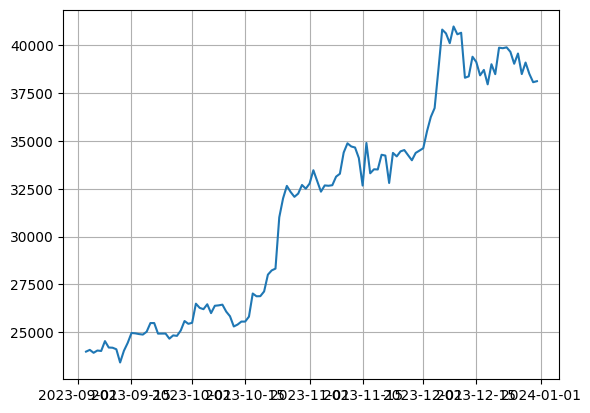

In [19]:
plt.grid()
plt.plot(dati['Timestamp'].iloc[-120:], dati['Price'].iloc[-120:])

# Function per il calcolo del rendimento ideale

In [20]:
def calcola_rendimento_portafoglio_ideale(capitale_iniziale, bitcoin_iniziali, lista_prezzi, min_acquisto, min_vendita, perc_commissione_acquisto, perc_commissione_vendita):
    capitale = capitale_iniziale
    bitcoin = bitcoin_iniziali
    comprato = False

    for i in range(len(lista_prezzi) - 1):
        # Compra al minimo
        if lista_prezzi[i] < lista_prezzi[i + 1] and not comprato and capitale >= min_acquisto:
            bitcoin_acquistati = (capitale * (1 - perc_commissione_acquisto)) / lista_prezzi[i]
            bitcoin += bitcoin_acquistati
            capitale = 0
            comprato = True
            # print(f'Bitcoin posseduti: {bitcoin}')
        # Vende al massimo
        elif lista_prezzi[i] > lista_prezzi[i + 1] and comprato and bitcoin * lista_prezzi[i] >= min_vendita:
            capitale_vendita = bitcoin * lista_prezzi[i] * (1 - perc_commissione_vendita)
            capitale += capitale_vendita
            bitcoin = 0
            comprato = False
            # print(f'Capitale posseduto: {capitale}')

    # Vende i bitcoin rimasti all'ultimo prezzo
    if comprato and bitcoin * lista_prezzi.iloc[-1] >= min_vendita:
        capitale += bitcoin * lista_prezzi.iloc[-1] * (1 - perc_commissione_vendita)
        bitcoin = 0
        # print(f'Capitale posseduto: {capitale}')
        # print(f'Bitcoin posseduti: {bitcoin}')

    valore_iniziale = capitale_iniziale + bitcoin_iniziali * lista_prezzi[0]
    valore_finale = capitale + bitcoin * lista_prezzi.iloc[-1]

    rendimento = valore_finale / valore_iniziale

    return [rendimento, valore_finale]

# Preparazione dei Periodi di 30 Giorni e train_test_split

In [21]:
# Estrarre periodi di lunghezza 30 giorni dai dati
L = 30
periods = [dati.iloc[i:i + L] for i in range(len(dati) - L + 1)]

# Suddivisione dei periodi in train (70%) e validation/test (30%)
train_periods, validation_periods = train_test_split(periods, test_size=0.3, random_state=42)
validation_periods, test_periods = train_test_split(validation_periods, test_size=0.5, random_state=42)

# Visualizzare il numero di periodi in ciascun insieme
print(f"Train periods: {len(train_periods)}, Validation periods: {len(validation_periods)}, Test periods: {len(test_periods)}")

Train periods: 2354, Validation periods: 505, Test periods: 505


## Calcolo per curiosità i "punteggi di sufficienza" di ognuno dei 3 set

In [22]:
# Parametri per calcola_rendimento_portafoglio_ideale
initial_cash = 1000
initial_btc = 0
min_acquisto = 0
min_vendita = 0
perc_commissione_acquisto = 0
perc_commissione_vendita = 0

# Funzione per calcolare il punteggio di sufficienza medio per un insieme di periodi
def calcola_punteggio_sufficienza_medio(periods):
    punteggi_sufficienza = []
    
    for period in periods:
        # Estrai la lista dei prezzi dal periodo
        lista_prezzi = period['Price'].reset_index(drop=True)
        
        # Calcola il rendimento ideale
        rendimento_ideale, _ = calcola_rendimento_portafoglio_ideale(
            capitale_iniziale=initial_cash,
            bitcoin_iniziali=initial_btc,
            lista_prezzi=pd.Series(lista_prezzi),
            min_acquisto=min_acquisto,
            min_vendita=min_vendita,
            perc_commissione_acquisto=perc_commissione_acquisto,
            perc_commissione_vendita=perc_commissione_vendita
        )
        
        # Calcola il punteggio di sufficienza per questo periodo
        punteggio_sufficienza = 1 / rendimento_ideale
        punteggi_sufficienza.append(punteggio_sufficienza)

    # Calcola e restituisce il punteggio di sufficienza medio
    punteggio_medio = np.mean(punteggi_sufficienza)
    return punteggio_medio

In [23]:
# Calcola il punteggio di sufficienza medio per ciascun insieme
punteggio_sufficienza_medio_train = calcola_punteggio_sufficienza_medio(train_periods)
punteggio_sufficienza_medio_validation = calcola_punteggio_sufficienza_medio(validation_periods)
punteggio_sufficienza_medio_test = calcola_punteggio_sufficienza_medio(test_periods)

# Stampa i risultati
print(f"Punteggio di sufficienza medio - Train: {punteggio_sufficienza_medio_train:.4f}")
print(f"Punteggio di sufficienza medio - Validation: {punteggio_sufficienza_medio_validation:.4f}")
print(f"Punteggio di sufficienza medio - Test: {punteggio_sufficienza_medio_test:.4f}")

Punteggio di sufficienza medio - Train: 0.7003
Punteggio di sufficienza medio - Validation: 0.7011
Punteggio di sufficienza medio - Test: 0.7095


# Definizione dell'Ambiente Personalizzato TradingEnv per Train e Validation

In [24]:
class TradingEnv(gym.Env):
    def __init__(self, periods, initial_cash, initial_btc, L, info_columns, portfolio_metrics,
                 min_acquisto=0, min_vendita=0, perc_commissione_acquisto=0, perc_commissione_vendita=0):
        super(TradingEnv, self).__init__()

        self.rng = np.random.default_rng(seed_value)  # Generatore per scegliere i periodi in modo riproducibile
        
        # Inizializzazione delle variabili di input
        self.periods = periods
        self.initial_cash = initial_cash
        self.initial_btc = initial_btc
        self.current_step = 0
        self.current_period = None
        self.initial_price = None
        self.L = L  # Numero di giorni di osservazione
        self.period_index = 0

        # Parametri della funzione ideale
        self.min_acquisto = min_acquisto
        self.min_vendita = min_vendita
        self.perc_commissione_acquisto = perc_commissione_acquisto
        self.perc_commissione_vendita = perc_commissione_vendita

        # Definisce le colonne di informazione e le metriche del portafoglio
        self.info_columns = info_columns
        self.portfolio_metrics = portfolio_metrics

        # Calcola la dimensione dello spazio di osservazione
        self.num_info_columns = len(self.info_columns)
        self.observation_size = self.L * self.num_info_columns + len(self.portfolio_metrics)
        
        # Spazio di azione e di osservazione
        self.action_space = spaces.Box(low=-1, high=1, shape=(1,), dtype=np.float32)
        self.observation_space = spaces.Box(low=0, high=np.inf, shape=(self.observation_size,), dtype=np.float32)

    # def reset(self):
    #     # Procede al prossimo periodo in sequenza
    #     self.current_period = self.periods[self.period_index].reset_index(drop=True)
        
    #     # Aggiorna l'indice per il periodo successivo
    #     self.period_index = (self.period_index + 1) % len(self.periods)

    #     # Reset delle variabili del portafoglio
    #     self.current_step = 0
    #     self.cash = self.initial_cash
    #     self.btc = self.initial_btc
    #     self.initial_price = self.current_period['Price'].iloc[self.current_step]
        
    #     # Valore iniziale del portafoglio e variabile per tracciare il valore del giorno precedente
    #     self.valore_iniziale = self.cash + self.btc * self.initial_price
    #     self.previous_total_value = self.valore_iniziale
        
    #     # Costruzione dell'osservazione iniziale
    #     obs = self.get_observation()
    #     return obs

    def reset(self, **kwargs):  # Accetta **kwargs per gestire seed e altri argomenti extra
        # Usa il generatore rng per scegliere un periodo in modo riproducibile
        self.current_period = self.periods[self.rng.integers(0, len(self.periods))].reset_index(drop=True)
        
        # Inizializza variabili di portafoglio e osservazione
        self.current_step = 0
        self.cash = self.initial_cash
        self.btc = self.initial_btc
        self.initial_price = self.current_period['Price'].iloc[self.current_step]
        self.valore_iniziale = self.cash + self.btc * self.initial_price
        self.previous_total_value = self.valore_iniziale
        
        obs = self.get_observation()
        return obs, {}


    def step(self, action):
        percentage = action[0]
        price = self.current_period['Price'].iloc[self.current_step]

        # Gestione dell'azione (acquisto, vendita o nessuna azione)
        if percentage < 0:  # Vendita
            btc_to_sell = -percentage * self.btc
            self.btc -= btc_to_sell
            self.cash += btc_to_sell * price
        elif percentage > 0:  # Acquisto
            cash_to_spend = percentage * self.cash
            btc_bought = cash_to_spend / price
            self.btc += btc_bought
            self.cash -= cash_to_spend

        # Avanza al prossimo passo temporale
        self.current_step += 1
        done = self.current_step >= len(self.current_period) - 1
        truncated = False  # Indica che l'episodio non è stato troncato manualmente

        # Calcola il valore totale del portafoglio
        total_value = self.cash + self.btc * price

        # Calcola la variazione del portafoglio come reward
        reward = total_value - self.previous_total_value
        self.previous_total_value = total_value  # Aggiorna il valore del giorno precedente

        # Costruisce l'osservazione aggiornata
        obs = self.get_observation()
        
        return obs, reward, done, truncated, {}

    def get_observation(self):
        # Crea l'osservazione in base a L giorni di info_columns e alle metriche del portafoglio
        obs = self.current_period[self.info_columns].values[:self.current_step + 1].flatten()
        obs = np.pad(obs, (0, self.L * self.num_info_columns - len(obs)), mode='constant')
        
        # Costruisce l'osservazione delle metriche del portafoglio
        total_value = self.cash + self.btc * self.current_period['Price'].iloc[self.current_step]
        portfolio_obs = []
        if 'cash' in self.portfolio_metrics:
            portfolio_obs.append(self.cash)
        if 'btc' in self.portfolio_metrics:
            portfolio_obs.append(self.btc)
        if 'total_value' in self.portfolio_metrics:
            portfolio_obs.append(total_value)
        
        # Aggiunge l'osservazione del portafoglio all'osservazione finale
        obs = np.append(obs, portfolio_obs)
        return obs

    def render(self):
        total_value = self.cash + self.btc * self.current_period['Price'].iloc[self.current_step]
        print(f'Step: {self.current_step}, Cash: {self.cash}, BTC: {self.btc}, Total Value: {total_value}')

# Creare gli ambienti di addestramento e di validazione

In [25]:
liquidità_iniziale = 1000
bitcoin_iniziali = 0
L = 30
info_columns = ['Price', 'Volume'] #['Price', 'Volume'] # Scegliere tra le colonne presenti nel dataset iniziale
portfolio_metrics = ['cash'] #['cash', 'btc', 'total_value'] # Scegliere tra 'cash', 'btc' e 'total_value' (o una combinazione di questi)
train_env = TradingEnv(periods=train_periods, initial_cash=liquidità_iniziale, initial_btc=bitcoin_iniziali, L=L, info_columns=info_columns, portfolio_metrics=portfolio_metrics)
validation_env = TradingEnv(periods=validation_periods, initial_cash=liquidità_iniziale, initial_btc=bitcoin_iniziali, L=L, info_columns=info_columns, portfolio_metrics=portfolio_metrics)

load_previous_model = True
previous_model = "Best models RL/best_model_RL_BTC_1000_10_200000_['Price', 'Volume']_['cash']_RS_8.zip"

# Addestrare l'agente con monitoraggio su validation

In [ ]:
# Definizione dei parametri con valori esemplificativi
liquidità_iniziale = 1000
bitcoin_iniziali = 0
L = 30
num_epochs = 1000  # Numero di epoche, cioè quante volte attraversare tutti i periodi di training
patience = 10  # Numero massimo di epoche senza miglioramento sul validation set prima di fermarsi
# Definisci il numero di timesteps di addestramento (regola per una durata adeguata)
n_timesteps = 200000  # Adatta questo valore in base alla complessità del modello e ai dati
detailed_logs = True # Mettere True se si vuole una stampa dettagliata per ogni epoca durante l'allenamento

best_validation_reward = -np.inf  # Reward migliore osservato finora
validation_rewards = []  # Lista dei reward di validazione per monitoraggio
no_improvement_count = 0  # Contatore per tenere traccia delle epoche senza miglioramento

# Nome del file per salvare i migliori pesi
best_model_path = f"Best models RL/best_model_RL_BTC_{num_epochs}_{patience}_{n_timesteps}_{info_columns}_{portfolio_metrics}_RS_{seed_value}.zip"

# Imposta train_env con tutti i periodi di addestramento
train_env = TradingEnv(
    periods=train_periods,
    initial_cash=liquidità_iniziale,
    initial_btc=bitcoin_iniziali,
    L=L,
    info_columns=info_columns,
    portfolio_metrics=portfolio_metrics
)

if load_previous_model:
    # Oppure carico un modello già salvato per continuare un addestramento
    model = PPO.load(previous_model, env=train_env)
    # Imposto il livello di verbosità desiderato (opzionale)
    model.verbose = 2
else:
    # Inizializzazione del modello PPO con il training environment
    model = PPO("MlpPolicy", train_env, verbose=2)

# Addestra il modello con early stopping monitorato sul validation set
for epoch in range(num_epochs):
    print(f"\n--- Epoch {epoch+1}/{num_epochs} ---")
    
    # Esegui un ciclo di addestramento per `n_timesteps`
    model.learn(total_timesteps=n_timesteps, reset_num_timesteps=False)

    # Valutazione su tutti i periodi di validation dopo ogni epoca
    validation_rewards_epoch = []
    for val_period_index, val_period in enumerate(validation_periods, start=1):
        validation_env = TradingEnv(
            periods=[val_period],
            initial_cash=liquidità_iniziale,
            initial_btc=bitcoin_iniziali,
            L=L,
            info_columns=info_columns,
            portfolio_metrics=portfolio_metrics
        )
        
        obs, _ = validation_env.reset()
        done = False
        total_reward = 0
        daily_rewards = []  # Per registrare i reward giornalieri
        while not done:
            action, _states = model.predict(obs, deterministic=True)
            obs, reward, done, truncated, _ = validation_env.step(action)
            total_reward += reward
            daily_rewards.append(reward)
            
        validation_rewards_epoch.append(total_reward)
        if detailed_logs:
            print(f"\nValidation period {val_period_index}:")
            print(f"Total reward for period: {total_reward}")
            print("Daily rewards:", daily_rewards)
            print("Final portfolio value:", validation_env.previous_total_value)
    
    # Calcola il reward medio di validation
    avg_validation_reward = np.mean(validation_rewards_epoch)
    validation_rewards.append(avg_validation_reward)
    print(f"Average validation reward at epoch {epoch+1}: {avg_validation_reward}")

    # Controllo per Early Stopping
    if avg_validation_reward > best_validation_reward:
        best_validation_reward = avg_validation_reward
        no_improvement_count = 0
        model.save(best_model_path)  # Salva i migliori pesi
        print(f"New best model saved with validation reward {avg_validation_reward}")
    else:
        no_improvement_count += 1
        print(f"No improvement count: {no_improvement_count}/{patience}")
        print(f"Best validation reward so far: {best_validation_reward}")

    if no_improvement_count >= patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement.")
        break

# Ripristina i migliori pesi salvati
if os.path.exists(best_model_path):
    model = PPO.load(best_model_path, env=train_env)  # Carica i pesi salvati nel modello
    print(f"Restored the best model weights from saved file with validation reward: {best_validation_reward}.")

# Best: 61.338393550479985

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.

--- Epoch 1/1000 ---
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29       |
|    ep_rew_mean     | 81.3     |
| time/              |          |
|    fps             | 297      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2410496  |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 29          |
|    ep_rew_mean          | 71.4        |
| time/                   |             |
|    fps                  | 246         |
|    iterations           | 2           |
|    time_elapsed         | 16          |
|    total_timesteps      | 2412544     |
| train/                  |             |
|    approx_kl            | 0.075395465 |
|    clip_fraction        | 0.353       |
|    clip_range           | 0.2         |
|    entropy_lo

# Test finale sui dati di test

In [ ]:
# Inizializza le variabili per calcolare il rendimento medio
total_returns = []
ideal_returns = []
punteggi_rendimento = []
punteggi_sufficienza = []

# Testa l'agente su ciascun periodo in test_periods
for period in test_periods:
    # Crea un ambiente per il periodo corrente
    test_env = TradingEnv(
        periods=[period],  # Passa solo il periodo corrente
        initial_cash=liquidità_iniziale, 
        initial_btc=bitcoin_iniziali, 
        L=L, 
        info_columns=info_columns, 
        portfolio_metrics=portfolio_metrics
    )

    obs, _ = test_env.reset()
    done = False
    lista_prezzi_test = [test_env.current_period['Price'].iloc[0]]  # Lista per registrare i prezzi durante il test

    # Esegui il test su questo periodo
    while not done:
        action, _states = model.predict(obs, deterministic=True)
        obs, reward, done, truncated, _ = test_env.step(action)
        lista_prezzi_test.append(test_env.current_period['Price'].iloc[test_env.current_step])

    # Calcola il rendimento finale del portafoglio dell'agente per questo periodo
    final_value = test_env.cash + test_env.btc * test_env.current_period['Price'].iloc[test_env.current_step]
    total_return = final_value / test_env.valore_iniziale
    total_returns.append(total_return)

    # Calcola il rendimento ideale usando la funzione `calcola_rendimento_portafoglio_ideale`
    rendimento_ideale, valore_finale_ideale = calcola_rendimento_portafoglio_ideale(
        capitale_iniziale=liquidità_iniziale, 
        bitcoin_iniziali=bitcoin_iniziali, 
        lista_prezzi=pd.Series(lista_prezzi_test), 
        min_acquisto=10, 
        min_vendita=10, 
        perc_commissione_acquisto=0.001, 
        perc_commissione_vendita=0.001
    )
    ideal_returns.append(rendimento_ideale)

    # Calcola il punteggio di rendimento per questo periodo
    punteggio_rendimento = total_return / rendimento_ideale if rendimento_ideale != 0 else 0
    punteggi_rendimento.append(punteggio_rendimento)

    # Stampa i risultati per ogni periodo
    # print(f"Total return on test period: {total_return}")
    # print(f"Ideal return on test period: {rendimento_ideale}")
    # print(f"Agent's final portfolio value: {final_value}")
    # print(f"Ideal final portfolio value: {valore_finale_ideale}")
    # print(f'Punteggio rendimento: {punteggio_rendimento}')
    # print(f'Punteggio di sufficienza: {punteggio_sufficienza}')

# Calcola le medie finali
avg_total_return = np.mean(total_returns)
avg_ideal_return = np.mean(ideal_returns)
avg_punteggio_rendimento = np.mean(punteggi_rendimento)

# Stampa i risultati finali
print(f"Media fattore di rendimento sui dati di test: {avg_total_return}")
print(f"Media fattore di rendimento ideale sui dati di test: {avg_ideal_return}")
print(f"Media punteggio rendimento sui dati di test: {avg_punteggio_rendimento}")
print(f"Media punteggio di sufficienza sui dati di test: {punteggio_sufficienza_medio_test}")

# Media punteggio rendimento sui dati di test: 0.7476366740370503

Media fattore di rendimento sui dati di test: 1.061973607320257
Media fattore di rendimento ideale sui dati di test: 1.4406768925836237
Media punteggio rendimento sui dati di test: 0.7475662181776146
Media punteggio di sufficienza sui dati di test: 0.7095252448346598


# Test finale su 1 dato di test casuale con grafico

In [ ]:
# Test finale su test_periods
test_env = TradingEnv(
    periods=test_periods, 
    initial_cash=liquidità_iniziale, 
    initial_btc=bitcoin_iniziali, 
    L=L, 
    info_columns=info_columns, 
    portfolio_metrics=portfolio_metrics
)

obs, _ = test_env.reset()
done = False
lista_prezzi_test = [test_env.current_period['Price'].iloc[0]]  # Lista per registrare i prezzi durante il test

while not done:
    action, _states = model.predict(obs, deterministic=True)
    obs, reward, done, truncated, _ = test_env.step(action)
    lista_prezzi_test.append(test_env.current_period['Price'].iloc[test_env.current_step])
    test_env.render()

# Calcola il rendimento finale del portafoglio dell'agente
final_value = test_env.cash + test_env.btc * test_env.current_period['Price'].iloc[test_env.current_step]
total_return = final_value / test_env.valore_iniziale  # Rendimento complessivo dell'agente

# Calcola il rendimento ideale usando la funzione `calcola_rendimento_portafoglio_ideale`
rendimento_ideale, valore_finale_ideale = calcola_rendimento_portafoglio_ideale(
    capitale_iniziale=liquidità_iniziale, 
    bitcoin_iniziali=bitcoin_iniziali, 
    lista_prezzi=pd.Series(lista_prezzi_test), 
    min_acquisto=10, 
    min_vendita=10, 
    perc_commissione_acquisto=0.001, 
    perc_commissione_vendita=0.001
)

# Stampa i risultati finali
print(f"Fattore di rendimento: {total_return}")
print(f"Fattore di rendimento ideale: {rendimento_ideale}")
print(f"Valore finale del portafoglio: {final_value}")
print(f"Valore finale ideale del portafoglio: {valore_finale_ideale}")
print(f'Punteggio rendimento: {total_return / rendimento_ideale}')
print(f'Punteggio considerato sufficiente: {calcola_punteggio_sufficienza_medio([pd.DataFrame({"Price": lista_prezzi_test})])}')

# 0.6473397279401845

Step: 1, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 1020.4845345705362
Step: 2, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 941.1986757410314
Step: 3, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 930.7363186953173
Step: 4, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 947.0435156972868
Step: 5, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 998.6792558900347
Step: 6, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 957.5384519884183
Step: 7, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 978.3883468663956
Step: 8, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 1028.9780569018617
Step: 9, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 1013.7971562738018
Step: 10, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 1021.684416874158
Step: 11, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 1032.6180938551536
Step: 12, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 981.3841986137685
Step: 13, Cash: 0.0, BTC: 0.42096084930495725, Total Value: 973.33712

In [ ]:
# Estrai i prezzi e le date dal periodo di test
test_dates = test_env.current_period['Timestamp']  # Assicurati che ci sia una colonna 'Timestamp' nei dati
test_prices = test_env.current_period['Price']

# Crea la figura dell'andamento dei prezzi
fig = go.Figure()

# Aggiungi una linea per l'andamento dei prezzi di test
fig.add_trace(go.Scatter(
    x=test_dates, 
    y=test_prices, 
    mode='lines',
    name='Prezzo BTC',
    line=dict(color='blue', width=2)
))

# Configurazione del layout del grafico
fig.update_layout(
    title="Andamento dei Prezzi di BTC durante il periodo di test",
    xaxis_title="Data",
    yaxis_title="Prezzo (€)",
    template="plotly_white",
    hovermode="x unified",
    width=1000,
    height=600
)

# Mostra il grafico
fig.show()

# Funzione per sapere cosa fare oggi in base al passato

In [ ]:
def get_trading_action(model, new_data):
    new_env = TradingEnv(periods=[new_data], initial_cash=liquidità_iniziale, initial_btc=bitcoin_iniziali, 
                                    L=L, info_columns=info_columns, portfolio_metrics=portfolio_metrics)
    obs, _ = new_env.reset()
    action, _states = model.predict(obs, deterministic=True)
    return action[0]

# Esempio di utilizzo su nuovi dati
new_data = dati.iloc[-L:]

action_today = get_trading_action(model, new_data)
print("Azione consigliata per oggi:", action_today)

Azione consigliata per oggi: 1.0


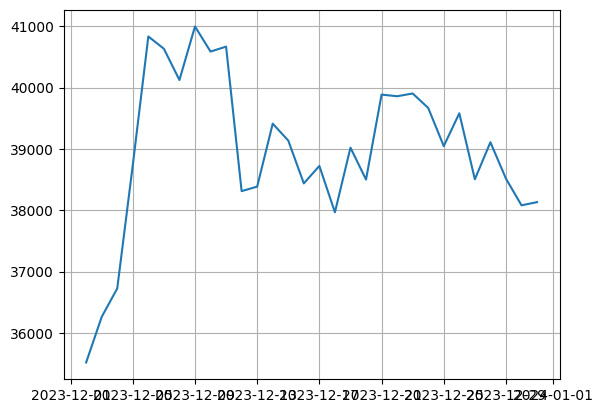

In [ ]:
plt.grid()
plt.plot(new_data['Timestamp'], new_data['Price']);

# Funzione per testare l'agente su più giorni (simulazione classica)

In [ ]:
# Funzione per simulare il trading su dati di test
def simulate_trading_on_test_data(model, dati_test_custom, L=30, initial_cash=1000, initial_btc=0):
    # Inizializza le variabili di portafoglio
    cash = initial_cash
    btc = initial_btc
    
    # Lista per accumulare i dati del log
    log_data = []
    
    # Ciclo su ogni giorno da L in poi per simulare le operazioni di trading
    for i in range(L, len(dati_test_custom)):
        # Crea la finestra dei dati passati di lunghezza L
        historical_data = dati_test_custom.iloc[i-L:i]
        
        # Estrarre il prezzo del giorno corrente
        current_price = dati_test_custom.iloc[i]['Price']
        current_timestamp = dati_test_custom.iloc[i]['Timestamp']
        
        # Usa il modello per prevedere l'azione da compiere oggi
        action = get_trading_action(model, historical_data)
        
        # Determina l'azione (acquisto, vendita o nulla)
        if action > 0:  # Acquisto
            cash_spent = action * cash
            btc_bought = cash_spent / current_price
            cash -= cash_spent
            btc += btc_bought
            action_type = 'Acquisto'
        elif action < 0:  # Vendita
            btc_sold = -action * btc
            cash_earned = btc_sold * current_price
            btc -= btc_sold
            cash += cash_earned
            action_type = 'Vendita'
        else:
            # Nessuna azione
            action_type = '-'
            cash_spent = 0
            btc_bought = 0
            cash_earned = 0
            btc_sold = 0

        # Calcola il valore totale del portafoglio alla fine della giornata
        total_value = cash + btc * current_price
        
        # Aggiungi una nuova riga al log
        log_data.append({
            'Timestamp': current_timestamp,
            'prezzo': current_price,
            'Azione': action_type,
            'Percentuale': action,
            'Liquidità spesa/guadagnata': cash_spent if action_type == 'Acquisto' else cash_earned if action_type == 'Vendita' else '-',
            'Bitcoin spesi/guadagnati': btc_bought if action_type == 'Acquisto' else btc_sold if action_type == 'Vendita' else '-',
            'Liquidità posseduta': cash,
            'bitcoin': btc,
            'valore_totale_portafoglio': total_value
        })
        
    # Converti i dati del log in un DataFrame
    log_df = pd.DataFrame(log_data)
    
    return log_df

In [ ]:
dati

,Timestamp,Price,Open,High,Low,Volume
0,2014-09-17,355.957367,359.546204,361.468506,351.586884,16389166
1,2014-09-18,328.539368,355.588409,355.505402,319.789459,26691849
2,2014-09-19,307.761139,328.278503,330.936707,298.921021,29560103
3,2014-09-20,318.758972,307.665253,329.978180,303.931244,28736826
4,2014-09-21,310.632446,318.120514,321.504517,306.502197,20702625
...,...,...,...,...,...,...
3388,2023-12-27,38504.562500,39568.429688,39571.453125,37778.320312,27190965041
3389,2023-12-28,39108.300781,38502.812500,39345.335938,38217.789062,22740505379
3390,2023-12-29,38515.289062,39131.113281,39415.761719,38211.789062,20773907848
3391,2023-12-30,38080.046875,38503.351562,38997.976562,37469.179688,23517721045


In [ ]:
# Parametri di input
initial_date = '2024-01-01'  # Data di inizio per la selezione casuale
final_date = '2024-04-24'    # Data di fine per la selezione casuale
n_days = 50                  # Numero di giorni da includere nel periodo casuale

# Filtrare i dati tra initial_date e final_date
dati_filtered = dati_originali[(dati_originali['Timestamp'] >= initial_date) & (dati_originali['Timestamp'] <= final_date)]

# Calcolare il massimo indice di partenza per un periodo di lunghezza n_days
max_start_index = len(dati_filtered) - n_days

# Selezionare un indice casuale di partenza per il periodo
if max_start_index > 0:
    start_index = random.randint(0, max_start_index)
    dati_test_custom = dati_filtered.iloc[start_index:start_index + n_days].reset_index(drop=True)
else:
    raise ValueError("L'intervallo specificato non contiene abbastanza dati per un periodo di n_days.")

# Esecuzione della simulazione di trading sui dati di test
log_df = simulate_trading_on_test_data(model, dati_test_custom)

# Visualizzare i primi risultati del log
log_df

,Timestamp,prezzo,Azione,Percentuale,Liquidità spesa/guadagnata,Bitcoin spesi/guadagnati,Liquidità posseduta,bitcoin,valore_totale_portafoglio
0,2024-03-18,62838.261719,Acquisto,1.0,1000.0,0.015914,0.0,0.015914,1000.000000
1,2024-03-19,62122.750000,Acquisto,1.0,0.0,0.000000,0.0,0.015914,988.613439
2,2024-03-20,56999.375000,Acquisto,1.0,0.0,0.000000,0.0,0.015914,907.080709
3,2024-03-21,62092.179688,Acquisto,1.0,0.0,0.000000,0.0,0.015914,988.126947
4,2024-03-22,60291.375000,Acquisto,1.0,0.0,0.000000,0.0,0.015914,959.469173
5,2024-03-23,58737.050781,Acquisto,1.0,0.0,0.000000,0.0,0.015914,934.733858
6,2024-03-24,58998.085938,Acquisto,1.0,0.0,0.000000,0.0,0.015914,938.887937
7,2024-03-25,62211.914062,Acquisto,1.0,0.0,0.000000,0.0,0.015914,990.032384
8,2024-03-26,64555.195312,Acquisto,1.0,0.0,0.000000,0.0,0.015914,1027.323060
9,2024-03-27,64607.664062,Acquisto,1.0,0.0,0.000000,0.0,0.015914,1028.158041


In [ ]:
# Funzione per calcolare la dimensione dei punti in base alla quantità e al massimo valore
def calcola_dimensione(quantita, max_quantita, min_size=10, max_size=50):
    return min_size + (max_size - min_size) * (quantita / max_quantita) if max_quantita != 0 else min_size

# Filtra gli acquisti e le vendite dal log delle transazioni
acquisti = log_df[(log_df['Azione'] == 'Acquisto') & (log_df['Liquidità spesa/guadagnata'] != 0)]
vendite = log_df[(log_df['Azione'] == 'Vendita') & (log_df['Liquidità spesa/guadagnata'] != 0)]

# Calcola il massimo valore speso per acquistare e il massimo valore guadagnato dalle vendite
max_acquisto = acquisti['Liquidità spesa/guadagnata'].max()
max_vendita = vendite['Liquidità spesa/guadagnata'].max()

# Calcola la dimensione dei punti in base al massimo valore di acquisto e vendita
dimensioni_acquisti = acquisti['Liquidità spesa/guadagnata'].apply(lambda x: calcola_dimensione(x, max_acquisto))
dimensioni_vendite = vendite['Liquidità spesa/guadagnata'].apply(lambda x: calcola_dimensione(x, max_vendita))

# Creazione del grafico dei prezzi con acquisti e vendite
fig = go.Figure()

# Linea dell'andamento dei prezzi
fig.add_trace(go.Scatter(
    x=log_df['Timestamp'],
    y=log_df['prezzo'],
    mode='lines',
    name='Prezzi Bitcoin',
    line=dict(color='blue', width=2),
    hoverinfo='x+y'
))

# Scatter plot per gli acquisti con dimensione proporzionale al valore speso
fig.add_trace(go.Scatter(
    x=acquisti['Timestamp'],
    y=acquisti['prezzo'],
    mode='markers',
    name='Acquisti',
    marker=dict(color='green', size=dimensioni_acquisti, opacity=0.7),
    text=[
        f"Timestamp: {timestamp}<br>Prezzo: {prezzo} €<br>Percentuale Acquisto: {round(percentuale * 100, 2)}%<br>Liquidità Spesa: {round(liquid_spesa, 2)} €<br>Bitcoin Acquistati: {round(btc_acq, 6)}<br>Liquidità: {round(liquid_tot, 2)} €<br>Bitcoin: {round(btc_poss, 6)}<br>Valore Portafoglio: {round(valore_port, 2)} €"
        for timestamp, prezzo, percentuale, liquid_spesa, btc_acq, liquid_tot, btc_poss, valore_port in zip(
            acquisti['Timestamp'],
            acquisti['prezzo'],
            acquisti['Percentuale'],
            acquisti['Liquidità spesa/guadagnata'],
            acquisti['Bitcoin spesi/guadagnati'],
            acquisti['Liquidità posseduta'],
            acquisti['bitcoin'],
            acquisti['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Scatter plot per le vendite con dimensione proporzionale al valore guadagnato
fig.add_trace(go.Scatter(
    x=vendite['Timestamp'],
    y=vendite['prezzo'],
    mode='markers',
    name='Vendite',
    marker=dict(color='red', size=dimensioni_vendite, opacity=0.7),
    text=[
        f"Timestamp: {timestamp}<br>Prezzo: {prezzo} €<br>Percentuale Vendita: {round(percentuale * 100, 2)}%<br>Liquidità Guadagnata: {round(liquid_guad, 2)} €<br>Bitcoin Venduti: {round(btc_vend, 6)}<br>Liquidità: {round(liquid_tot, 2)} €<br>Bitcoin: {round(btc_poss, 6)}<br>Valore Portafoglio: {round(valore_port, 2)} €"
        for timestamp, prezzo, percentuale, liquid_guad, btc_vend, liquid_tot, btc_poss, valore_port in zip(
            vendite['Timestamp'],
            vendite['prezzo'],
            vendite['Percentuale'],
            vendite['Liquidità spesa/guadagnata'],
            vendite['Bitcoin spesi/guadagnati'],
            vendite['Liquidità posseduta'],
            vendite['bitcoin'],
            vendite['valore_totale_portafoglio']
        )
    ],
    hoverinfo='text'
))

# Configurazione del layout del grafico
fig.update_layout(
    title='Andamento Prezzi Bitcoin con Transazioni di Acquisto e Vendita',
    xaxis_title='Data',
    yaxis_title='Prezzo (€)',
    hovermode='closest',
    template='plotly_white',
    legend=dict(yanchor="top", y=0.99, xanchor="left", x=0.01),
    width=1200,
    height=800,
    xaxis=dict(
        rangeslider=dict(visible=True),  # Abilita il range slider
        type="date"  # Imposta l'asse x come asse temporale
    )
)

# Mostra il grafico interattivo
fig.show()

In [ ]:
rendimento_ideale, portafoglio_finale_ideale = calcola_rendimento_portafoglio_ideale(liquidità_iniziale, bitcoin_iniziali, log_df['prezzo'], 0, 0, 0, 0)
print('Rendimento ideale:', round(rendimento_ideale, 2))
print('Portafoglio finale ideale in euro:', round(portafoglio_finale_ideale, 2))

valore_iniziale = log_df['valore_totale_portafoglio'].iloc[0]
valore_finale = log_df['valore_totale_portafoglio'].iloc[-1]
rendimento = valore_finale / valore_iniziale

print(f"Rendimento del portafoglio: {round(rendimento, 2)}")
print(f'Punteggio rendimento: {round(rendimento / rendimento_ideale *100, 2)}%')
print(f"Punteggio considerato sufficiente: {round(calcola_punteggio_sufficienza_medio([pd.DataFrame({'Price': log_df['prezzo']})]) * 100, 2)}%")
print(f"Valore finale del portafoglio in euro: {round(log_df['valore_totale_portafoglio'].iloc[-1], 2)}")

# Punteggio rendimento: 80.43%

Rendimento ideale: 1.3
Portafoglio finale ideale in euro: 1303.71
Rendimento del portafoglio: 1.0
Punteggio rendimento: 76.36%
Punteggio considerato sufficiente: 76.7%
Valore finale del portafoglio in euro: 995.57
